RNNs are not easily optimizable with the first order gradient base techniques. We have to understand how the activations and gradients behave during training.


In [2]:
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
words = open('datasets/names.txt').read().splitlines()
print(words[:10])  # Print the first 10 words to verify
print(f"Total words loaded: {len(words)}")

chars = sorted(list(set(''.join(words))))

# string to index mapping 
stoi = { ch:i+1 for i,ch in enumerate(chars)}
stoi['.'] = 0
print(f"String to index mapping: {stoi}")

itos = {i:s for s,i in stoi.items()}
print(itos)

vocab_size = len(itos)

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']
Total words loaded: 32033
String to index mapping: {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
# Build the dataset
import random
from typing import List

block_size = 3

def build_dataset(words: List[str], context_len: int=3):
    block_size = context_len 
    
    X,Y = [],[]

    block_size = 3

    for w in words:
        context = [0] * block_size

        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)

            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]

    # print(X)
    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X,Y
    # X.shape, X.dtype, Y.shape, Y.dtype


random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_train,Y_train = build_dataset(words[:n1],block_size)
X_dev,Y_dev = build_dataset(words[n1:n2],block_size)
X_test,Y_test = build_dataset(words[n2:],block_size)

X_train.shape, X_dev.shape, X_test.shape

(torch.Size([182625, 3]), torch.Size([22655, 3]), torch.Size([22866, 3]))

In [5]:
# MLP

n_embed = 10
n_hidden = 200

g = torch.Generator().manual_seed(345)
C = torch.randn((vocab_size,n_embed), generator=g)
W1 = torch.randn((n_embed*block_size,n_hidden),generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden,vocab_size),generator=g)
b2 = torch.randn(vocab_size, generator=g)

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True


✅ Why Take the Logarithm of the Loss?
1. Better Visualization of Convergence
   If you're plotting the loss over time:
   * Early in training, loss might start high (e.g., 1 or even 10)
   * Later, it gets very small (e.g., 0.01, 0.001, etc.)

   The raw loss values can span several orders of magnitude, so plotting them linearly can squash the curve and hide small improvements.

✅ Taking the log compresses the scale and makes it easier to visualize smooth progress.

example:

| Epoch | Raw Loss | log10(Loss) |
| ----- | -------- | ----------- |
| 0     |  1.0     |    0.0      |
| 10    |  0.1     |   -1.0      |
| 20    |  0.01    |   -2.0      |

This shows very clearly how many orders of magnitude the loss improved.

✅ Summary: .log10 is done to:
  * Smooth the training curve visualization
  * Help compare improvements on a logarithmic scale
  * Avoid steep plots when loss decreases rapidly

### Problem-1 (Initialization-Initial Loss)

In [6]:
max_steps = 200000
batch_size = 32
loss_l = []
steps_l = []

for epoch in range(max_steps):
    ix = torch.randint(0, X_train.shape[0],(batch_size,),generator=g)

    Xb, Yb = X_train[ix], Y_train[ix]

    emb = C[Xb] # (batch_size, block_size, n_embed)
    h = torch.tanh(emb.view(-1,block_size*n_embed) @ W1 + b1)
    logits = h @ W2 + b2

    loss = F.cross_entropy(logits,Yb)

    steps_l.append(epoch)
    loss_l.append(loss.log10().item()) # smoothens the loss for good visualization

    for p in parameters:
        p.grad = None
    
    loss.backward()

    lr = 0.1 if epoch < int((max_steps)/2) else 0.01
    for p in parameters:
        p.data += -lr*p.grad

    # tracking stats
    if epoch % 10000 == 0:
        print(f"Step {epoch}/{max_steps:7d}, Loss: {loss.item():.4f}, Learning Rate: {lr:.4f}")
    


Step 0/ 200000, Loss: 29.0844, Learning Rate: 0.1000
Step 10000/ 200000, Loss: 2.4052, Learning Rate: 0.1000
Step 20000/ 200000, Loss: 2.5498, Learning Rate: 0.1000
Step 30000/ 200000, Loss: 2.5990, Learning Rate: 0.1000
Step 40000/ 200000, Loss: 2.3487, Learning Rate: 0.1000
Step 50000/ 200000, Loss: 2.1629, Learning Rate: 0.1000
Step 60000/ 200000, Loss: 2.2395, Learning Rate: 0.1000
Step 70000/ 200000, Loss: 2.2385, Learning Rate: 0.1000
Step 80000/ 200000, Loss: 2.2230, Learning Rate: 0.1000
Step 90000/ 200000, Loss: 2.3565, Learning Rate: 0.1000
Step 100000/ 200000, Loss: 2.3355, Learning Rate: 0.0100
Step 110000/ 200000, Loss: 2.1119, Learning Rate: 0.0100
Step 120000/ 200000, Loss: 2.3044, Learning Rate: 0.0100
Step 130000/ 200000, Loss: 2.2294, Learning Rate: 0.0100
Step 140000/ 200000, Loss: 2.1339, Learning Rate: 0.0100
Step 150000/ 200000, Loss: 2.1952, Learning Rate: 0.0100
Step 160000/ 200000, Loss: 1.8753, Learning Rate: 0.0100
Step 170000/ 200000, Loss: 2.0594, Learning 

In [7]:
@torch.no_grad() # decorator this prevents gradient tracking which causes the evaluation results to be forward pass faster

def split_loss(split):
    x,y = {
        'train': (X_train,Y_train),
        'dev': (X_dev,Y_dev),
        'test': (X_test,Y_test)
    }[split]

    emb = C[x]
    h = torch.tanh(emb.view(-1,block_size*n_embed) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,y)

    print(f'{split} Loss: ',loss.item())

split_loss('train')
split_loss('dev')
    

train Loss:  2.118352174758911
dev Loss:  2.169837474822998


Our network is improperly configured at initialization.

The first iteration loss is too high for the given network, in training of neural nets it is almost the case that you will have rough idea for what loss to expect at initialization, which depends on the loss function and the problem setup. 

Why ?

In the First step of train data, which is given 3 characters as input it will predict the next character, so as we have an untrained neural network, all the 27 characters have an equal probability to be the next character.

Which means the prob should be 1/27.

Now loss is -log(1/27) -> 3.295 which is much much lower when compared to 18.

In my case at initialization, some characters are having high probability and some characters very low in that case the loss will be huge.

### Lets take different initialization examples.

In [8]:
# lets say we have only 4 characters 
logits = torch.tensor([0.0,0.0,0.0,0.0]) # logits for 4 characters
probs = F.softmax(logits, dim=0) # convert logits to probabilities
loss = probs[1].log()
probs, loss

(tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(-1.3863))

As this is uniform we see the loss is small, in this case it doesnt matter if it is index 1, 2, 3, the loss will be low and near if the logits are uniformally distributed.

In [9]:
logits = torch.tensor([0.0,5.0,0.0,0.0]) # logits for 4 characters
probs = F.softmax(logits, dim=0) # convert logits to probabilities
loss = probs[1].log()
probs, loss

(tensor([0.0066, 0.9802, 0.0066, 0.0066]), tensor(-0.0200))

Here we notice if the initialization was random and by luck the target is similar to the one alloted with high probablity (first initialization) then the loss will be very less as we predicted the right output with high probablity.

In [10]:
logits = torch.tensor([0.0,0.0,5.0,0.0]) # logits for 4 characters
probs = F.softmax(logits, dim=0) # convert logits to probabilities
loss = probs[1].log()
probs, loss

(tensor([0.0066, 0.0066, 0.9802, 0.0066]), tensor(-5.0200))

But now we can notice here that because of random initialization when our actual target, it leads to a bad prediction and assigns a big loss.


In [11]:
logits = torch.randn(4) * 10 # logits for 4 characters
probs = F.softmax(logits, dim=0) # convert logits to probabilities
loss = probs[1].log()
probs, loss

(tensor([2.1291e-07, 8.0153e-07, 9.9994e-01, 5.5530e-05]), tensor(-14.0367))

If the logits are near zero, for most of the part the losses will be low.

But if the logits are at extreme values the losses will be huge (as the network is initialized with random weights first prediction even though its wrong should lead to ouput an extreme loss)

So inorder to make this right start for initialization, we will set the prob close to zero. 

For this lets see logits = h @ W2 + b2

To make logits closer to zero, we will make   

1) b2 = 0 at intialization   
2) W2 will be very small ( torch.randn() * 0.01 )


In [12]:
# MLP

n_embed = 10
n_hidden = 200

g = torch.Generator().manual_seed(345)
C = torch.randn((vocab_size,n_embed), generator=g)
W1 = torch.randn((n_embed*block_size,n_hidden),generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden,vocab_size),generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True


In [13]:
max_steps = 200000
batch_size = 32
loss_l = []
steps_l = []

for epoch in range(max_steps):
    ix = torch.randint(0, X_train.shape[0],(batch_size,),generator=g)

    Xb, Yb = X_train[ix], Y_train[ix]

    emb = C[Xb] # (batch_size, block_size, n_embed)
    h = torch.tanh(emb.view(-1,block_size*n_embed) @ W1 + b1)
    logits = h @ W2 + b2

    loss = F.cross_entropy(logits,Yb)

    steps_l.append(epoch)
    loss_l.append(loss.log10().item()) # smoothens the loss for good visualization

    for p in parameters:
        p.grad = None
    
    loss.backward()

    lr = 0.1 if epoch < int((max_steps)/2) else 0.01
    for p in parameters:
        p.data += -lr*p.grad

    # tracking stats
    if epoch % 10000 == 0:
        print(f"Step {epoch}/{max_steps:7d}, Loss: {loss.item():.4f}, Learning Rate: {lr:.4f}")
    


Step 0/ 200000, Loss: 3.3265, Learning Rate: 0.1000
Step 10000/ 200000, Loss: 2.2972, Learning Rate: 0.1000
Step 20000/ 200000, Loss: 2.2875, Learning Rate: 0.1000
Step 30000/ 200000, Loss: 2.3932, Learning Rate: 0.1000
Step 40000/ 200000, Loss: 2.1389, Learning Rate: 0.1000
Step 50000/ 200000, Loss: 1.8227, Learning Rate: 0.1000
Step 60000/ 200000, Loss: 2.2273, Learning Rate: 0.1000
Step 70000/ 200000, Loss: 2.0551, Learning Rate: 0.1000
Step 80000/ 200000, Loss: 1.9834, Learning Rate: 0.1000
Step 90000/ 200000, Loss: 2.1694, Learning Rate: 0.1000
Step 100000/ 200000, Loss: 2.2360, Learning Rate: 0.0100
Step 110000/ 200000, Loss: 1.8407, Learning Rate: 0.0100
Step 120000/ 200000, Loss: 2.1840, Learning Rate: 0.0100
Step 130000/ 200000, Loss: 1.9761, Learning Rate: 0.0100
Step 140000/ 200000, Loss: 1.9979, Learning Rate: 0.0100
Step 150000/ 200000, Loss: 2.0850, Learning Rate: 0.0100
Step 160000/ 200000, Loss: 1.8401, Learning Rate: 0.0100
Step 170000/ 200000, Loss: 2.0509, Learning R

Now we can notice that the initialization loss is in the correct range.

In [14]:
split_loss('train')
split_loss('dev')

train Loss:  2.0691044330596924
dev Loss:  2.136845588684082


Why doesnt the hockey stick shown in this graph ?

1) As we initialized the weights correctly in such a way that, at the first step the equal probablity was given to the next predicting charac.
2) We are spending more time on optimizing the neural network actually, instead of spending several 1000s of iterations on squashing down the weights (because they were very to extreme during the initialization).

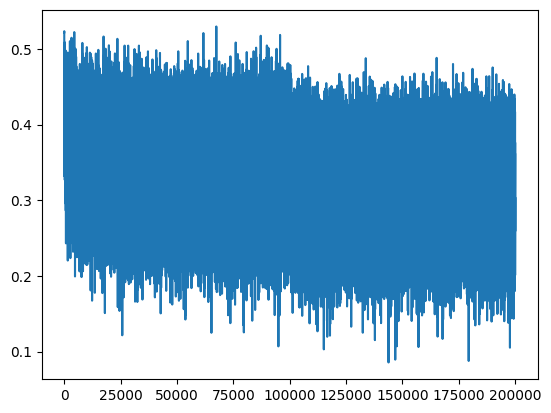

In [15]:
plt.plot(steps_l, loss_l)

### Problem-2 (Initialization, Fixing Saturated tanh)



Activations of the hidden states (h)

In [16]:
# MLP

n_embed = 10
n_hidden = 200

g = torch.Generator().manual_seed(345)
C = torch.randn((vocab_size,n_embed), generator=g)
W1 = torch.randn((n_embed*block_size,n_hidden),generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden,vocab_size),generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True


In [17]:
max_steps = 200000
batch_size = 32
loss_l = []
steps_l = []

for epoch in range(max_steps):
    ix = torch.randint(0, X_train.shape[0],(batch_size,),generator=g)

    Xb, Yb = X_train[ix], Y_train[ix]

    emb = C[Xb] # (batch_size, block_size, n_embed)
    h_preact = emb.view(-1,block_size*n_embed) @ W1 + b1
    h = torch.tanh(h_preact)
    logits = h @ W2 + b2

    loss = F.cross_entropy(logits,Yb)

    steps_l.append(epoch)
    loss_l.append(loss.log10().item()) # smoothens the loss for good visualization

    for p in parameters:
        p.grad = None
    
    loss.backward()

    lr = 0.1 if epoch < int((max_steps)/2) else 0.01
    for p in parameters:
        p.data += -lr*p.grad

    # tracking stats
    if epoch % 10000 == 0:
        print(f"Step {epoch}/{max_steps:7d}, Loss: {loss.item():.4f}, Learning Rate: {lr:.4f}")
    
    break


Step 0/ 200000, Loss: 3.3265, Learning Rate: 0.1000


The problem is we see a lot of -1s and 1s, lets look at the distribution of value h (using histogram)

In [18]:
h[0]

tensor([ 0.2544, -0.7316,  1.0000,  0.9960,  1.0000, -1.0000,  0.9968,  1.0000,
         0.9999,  1.0000, -1.0000,  0.9919, -1.0000, -0.9980, -0.7324, -1.0000,
         0.5264, -1.0000, -0.9933,  0.5863, -0.9994, -0.5933,  0.2044, -0.9979,
         0.9981, -0.6196, -1.0000, -0.9984,  0.9929,  1.0000,  0.5179, -1.0000,
        -1.0000,  0.9913,  0.9997, -1.0000,  1.0000, -0.0626,  1.0000,  0.9984,
         0.9759, -0.9959,  0.9998,  0.9999, -0.7551, -1.0000,  0.5369,  0.9833,
         0.9981, -1.0000, -0.5629, -0.9986,  0.9957,  1.0000, -0.9943,  1.0000,
         0.9964, -0.2727,  0.9899,  1.0000,  0.2488, -0.9959,  0.9957,  0.9999,
        -0.2237,  1.0000, -0.9344, -0.9832,  0.3502, -0.9977,  0.9334,  0.9997,
         0.9998, -0.3707, -0.9999,  1.0000,  0.9682,  0.5312,  0.9969,  0.6064,
        -0.4649,  1.0000, -1.0000,  1.0000,  0.3221, -0.9622, -0.9990,  0.7210,
         0.9994,  0.9999, -0.9998,  0.1393, -1.0000, -0.9951,  0.7871, -0.9996,
        -0.4611,  0.9930, -0.9992,  0.99

(array([2250.,  151.,   82.,   60.,   64.,   55.,   52.,   27.,   24.,
          36.,   32.,   17.,   19.,   30.,   20.,   15.,   18.,   15.,
          20.,   17.,   23.,   15.,   18.,   30.,   27.,   24.,   23.,
          19.,   22.,   28.,   24.,   26.,   17.,   29.,   30.,   20.,
          19.,   29.,   40.,   30.,   42.,   29.,   35.,   40.,   41.,
          39.,   61.,   93.,  154., 2369.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

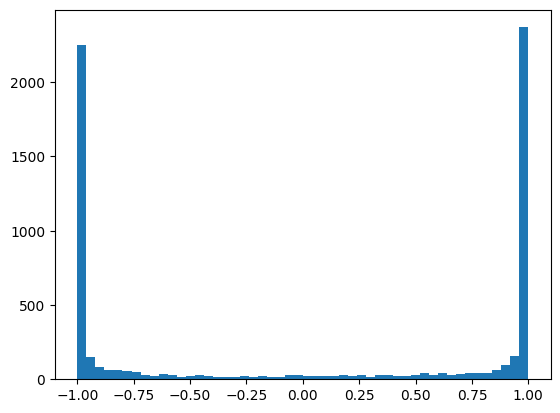

In [19]:
plt.hist(h.view(-1).tolist(),50)

We observe most of them take value -1 or 1, the tanh is very very active, to see why is this the case we will see the input before activation.

(array([  1.,   2.,   4.,   6.,   3.,  17.,  21.,  20.,  33.,  45.,  64.,
         83., 119., 161., 156., 199., 279., 305., 339., 366., 374., 385.,
        476., 370., 368., 411., 329., 302., 238., 194., 157., 144., 131.,
         81.,  64.,  52.,  26.,  23.,  22.,  14.,   7.,   1.,   4.,   1.,
          1.,   0.,   0.,   0.,   0.,   2.]),
 array([-19.33041954, -18.46334709, -17.59627464, -16.72920219,
        -15.86212975, -14.9950573 , -14.12798485, -13.2609124 ,
        -12.39383995, -11.5267675 , -10.65969505,  -9.7926226 ,
         -8.92555016,  -8.05847771,  -7.19140526,  -6.32433281,
         -5.45726036,  -4.59018791,  -3.72311546,  -2.85604301,
         -1.98897057,  -1.12189812,  -0.25482567,   0.61224678,
          1.47931923,   2.34639168,   3.21346413,   4.08053658,
          4.94760902,   5.81468147,   6.68175392,   7.54882637,
          8.41589882,   9.28297127,  10.15004372,  11.01711617,
         11.88418861,  12.75126106,  13.61833351,  14.48540596,
         15.352478

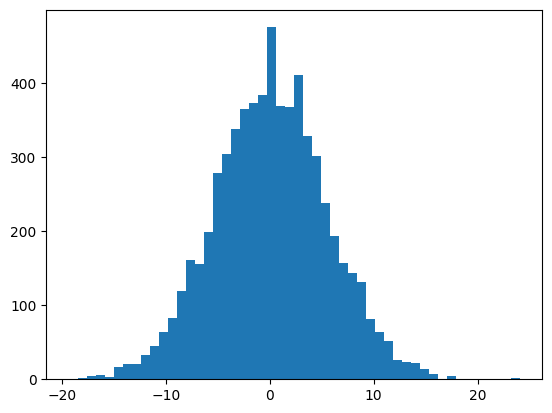

In [20]:
plt.hist(h_preact.view(-1).tolist(),50)

The distribution of the preactivations is very very broad.

If new to neural networks then u might not see this as an issue, but if you are well-versed in the art of back propagation, and then you look at the distribution of tanh and then you are sweating.


### Vanishing Gradient Problem

```

def tanh(self):  
    x = self.data
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    out = Value(t, (self,), 'tanh')

    def _backward():
        self.grad = (1 - t**2) * out.grad
    
    out._backward = _backward
    return out
```
If we notice in out tanh function we observe that in the backward pass the grads are updated 

self.grad = (1 - t**2) * out.grad, but as we know majority of the neurons are outputing close to -1 or 1 which will lead to no updation of gradients in the tanh function.

* We have the tanh neuron lets say if its output is 1  then changing the input will not change the output of the tanh too much as its in the flat region of the tanh.

* Therefore there is no impact on the loss. The weights and the biases along with the tanh neuron do not impact the loss because the output of the tanh neuron is in the flat region of tanh 

* Another thing to notice is that the gradient flowing through tanh will only ever decrease and the amount that it decreases is proportional to (1-t^2) [t -> output from tanh node]. When t=0 then the tanh becomes inactive and the gradient just passes through to its input weights and biases. (in the backward propagation).

### Now the main point

The concern here is if all of these outputs **h** are in the flat regions of -1 and 1 then the gradients that are flowing through the network will vanish/destroyed at this layer, which means that the parameters W1 and b1 are not getting updated, in out training process. 

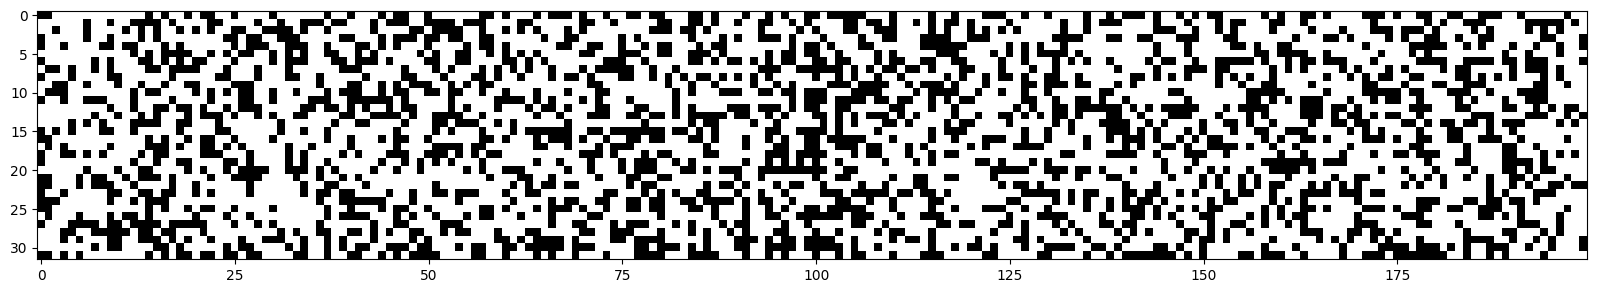

In [21]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

Here we can observe for our 32 batch input, which is each batch contains 3 input characters (3*30 as an input).

For each of those input batch we observe that the white regions representing the condition h.abs() > 0.99 as True, which means that majority of the inputs are generating close to 1 or -1.

In all these cases the backward propagation will be destroyed.

* We would be in a lot of trouble if any one of the 200 neurons, are leading to all tanh = 1 or -1, which is if it was the case that entire column in the above image is white, in that case we have what is called the dead neuron.

* This could be a tanh neuron were the initialization of weights and biases, could be such that no such input/examples ever activates this tanh, which is if all the examples/input land on the tail, then this neuron will never learn which is it will be dead neuron.

* In our case we dont see any neuron with all the examples/inputs without having any effect on the activation, so few examples/input are leading to learning.  
  
    
Its not just for tanh, its also for other activation functions.  

1) Same in the case of sigmoid as it has a squashing neuron, on both positive and negative sides.
2) **Relu** has completely flat region in the negative input side, so the gradient will pass through if input to the **ReLu** will be positive otherwise it will shut it off. So if we are using a **ReLu** neuron and we observe for each sample/input the neurons are not getting activated then it means the inputs are near the negative side which leads to zero output, which leads to its weights and biases not learning/(or no gradient updation).
3) This dead neuron can happen in the initialization (where the weights and biases lead to that kind of situation), and can also happen during optimization, lets say we have a too high of a learning rate for example sometimes the neurons have too much of a gradient and they get knocked out of the data manifold. From there on not example/input activates this neuron. And then the neuron remains dead forever.
4) So when you train your neural net after we get the last loss, we should see the neurons that are not getting activated by passing an entire training seeing the neurons output. As during training these **ReLu** neurons are changing ,moving etc, and because of a high gradient by chance they get knocked off and then nothing ever activates them, from then on they are just dead.
5) **Leaky ReLu** will not suffer this as it doesnt have a flat part, but **ELU** may face these kind of issues, as it has a flat region in the negative side.






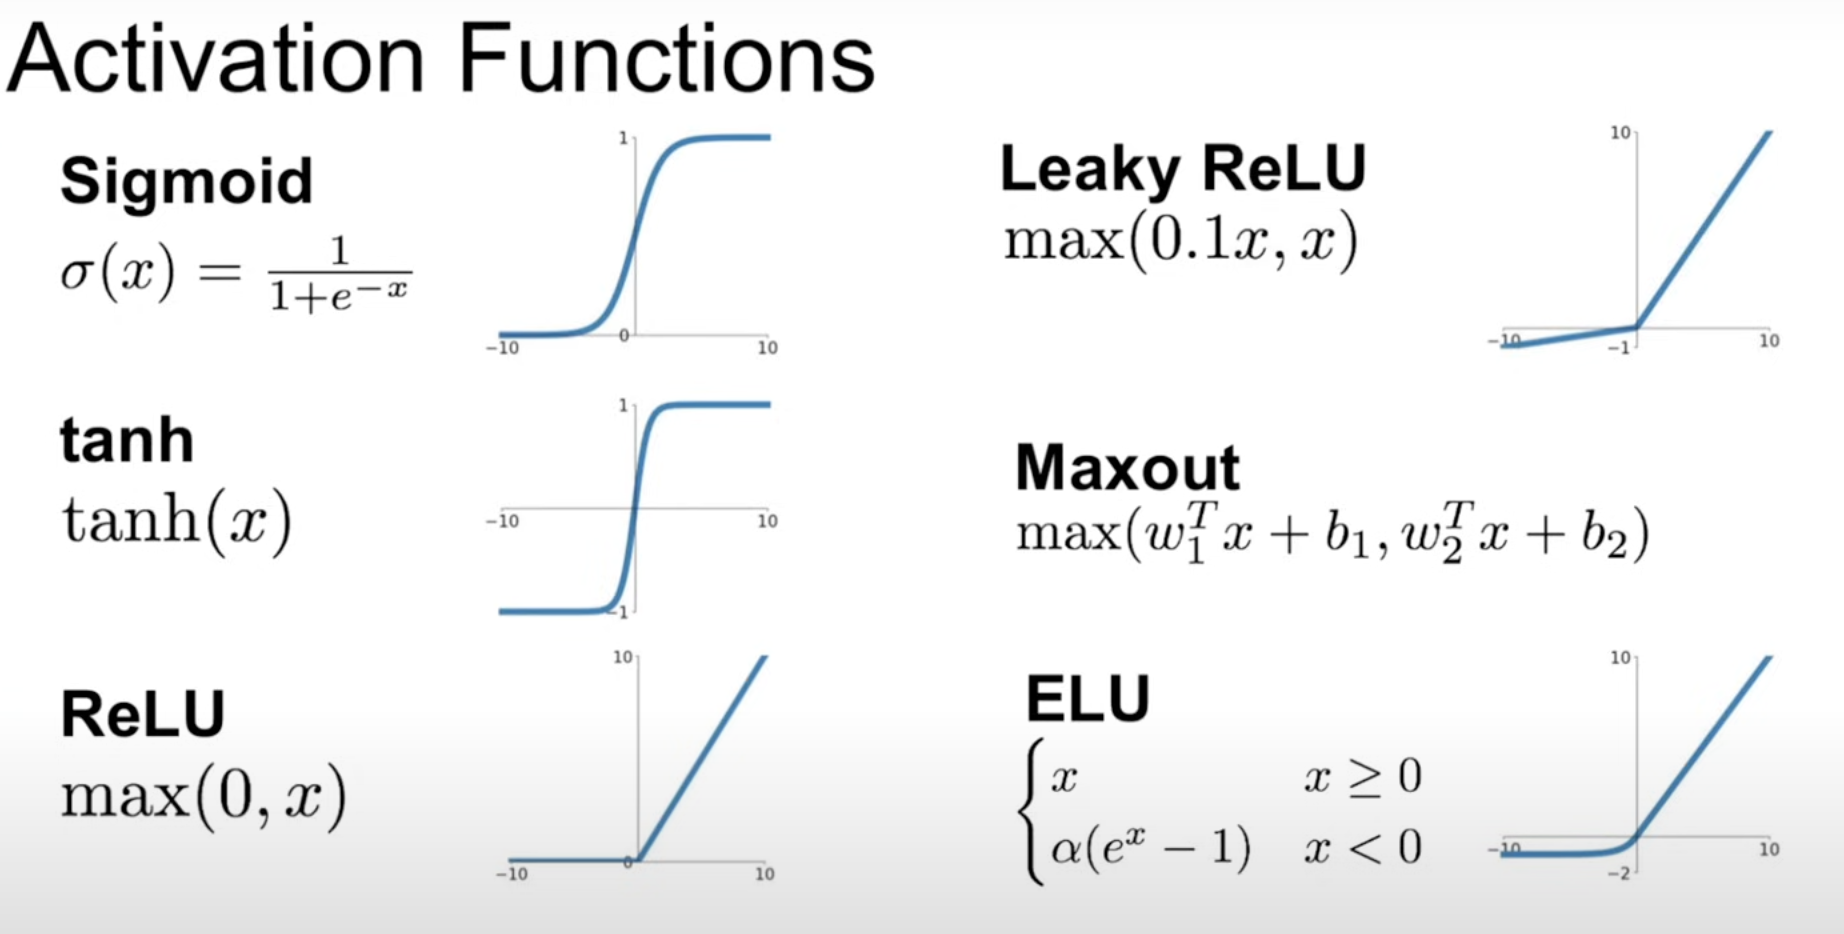



So now based on the distribution, we observe that the hpreact has wide range -20 to 20, we have to reduce this so that there is more learning in the neural network.

In [22]:
# Now to prevent this tanh ditribution being 1 and -1 more we need to make
# hpreact closer to 0, we can do this by scaling the weights down

n_embed = 10
n_hidden = 200

g = torch.Generator().manual_seed(345)
C = torch.randn((vocab_size,n_embed), generator=g)
W1 = torch.randn((n_embed*block_size,n_hidden),generator=g) * 0.1
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden,vocab_size),generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True


In [23]:
max_steps = 200000
batch_size = 32
loss_l = []
steps_l = []

for epoch in range(max_steps):
    ix = torch.randint(0, X_train.shape[0],(batch_size,),generator=g)

    Xb, Yb = X_train[ix], Y_train[ix]

    emb = C[Xb] # (batch_size, block_size, n_embed)
    h_preact = emb.view(-1,block_size*n_embed) @ W1 + b1
    h = torch.tanh(h_preact)
    logits = h @ W2 + b2

    loss = F.cross_entropy(logits,Yb)

    steps_l.append(epoch)
    loss_l.append(loss.log10().item()) # smoothens the loss for good visualization

    for p in parameters:
        p.grad = None
    
    loss.backward()

    lr = 0.1 if epoch < int((max_steps)/2) else 0.01
    for p in parameters:
        p.data += -lr*p.grad

    # tracking stats
    if epoch % 10000 == 0:
        print(f"Step {epoch}/{max_steps:7d}, Loss: {loss.item():.4f}, Learning Rate: {lr:.4f}")
    
    # break


Step 0/ 200000, Loss: 3.3047, Learning Rate: 0.1000
Step 10000/ 200000, Loss: 2.0705, Learning Rate: 0.1000
Step 20000/ 200000, Loss: 2.2624, Learning Rate: 0.1000
Step 30000/ 200000, Loss: 2.4000, Learning Rate: 0.1000
Step 40000/ 200000, Loss: 2.0552, Learning Rate: 0.1000
Step 50000/ 200000, Loss: 1.6847, Learning Rate: 0.1000
Step 60000/ 200000, Loss: 2.0371, Learning Rate: 0.1000
Step 70000/ 200000, Loss: 2.0365, Learning Rate: 0.1000
Step 80000/ 200000, Loss: 2.0323, Learning Rate: 0.1000
Step 90000/ 200000, Loss: 2.0517, Learning Rate: 0.1000
Step 100000/ 200000, Loss: 2.1057, Learning Rate: 0.0100
Step 110000/ 200000, Loss: 1.8518, Learning Rate: 0.0100
Step 120000/ 200000, Loss: 2.0069, Learning Rate: 0.0100
Step 130000/ 200000, Loss: 2.0745, Learning Rate: 0.0100
Step 140000/ 200000, Loss: 2.1081, Learning Rate: 0.0100
Step 150000/ 200000, Loss: 2.1426, Learning Rate: 0.0100
Step 160000/ 200000, Loss: 1.7615, Learning Rate: 0.0100
Step 170000/ 200000, Loss: 1.9761, Learning R

Now lets look at hpreact distribution

(array([2.00e+00, 1.00e+00, 0.00e+00, 0.00e+00, 2.00e+00, 2.00e+00,
        4.00e+00, 4.00e+00, 7.00e+00, 6.00e+00, 1.10e+01, 1.50e+01,
        2.90e+01, 2.40e+01, 2.90e+01, 4.60e+01, 5.40e+01, 7.90e+01,
        8.80e+01, 1.13e+02, 1.43e+02, 1.67e+02, 2.09e+02, 2.48e+02,
        2.78e+02, 3.91e+02, 2.16e+03, 6.03e+02, 3.37e+02, 2.54e+02,
        2.15e+02, 1.82e+02, 1.45e+02, 1.13e+02, 9.50e+01, 7.00e+01,
        7.10e+01, 4.10e+01, 3.90e+01, 4.00e+01, 2.20e+01, 1.50e+01,
        1.20e+01, 8.00e+00, 7.00e+00, 9.00e+00, 3.00e+00, 3.00e+00,
        1.00e+00, 3.00e+00]),
 array([-10.98683167, -10.57580372, -10.16477577,  -9.75374783,
         -9.34271988,  -8.93169193,  -8.52066399,  -8.10963604,
         -7.69860809,  -7.28758015,  -6.8765522 ,  -6.46552425,
         -6.05449631,  -5.64346836,  -5.23244041,  -4.82141247,
         -4.41038452,  -3.99935658,  -3.58832863,  -3.17730068,
         -2.76627274,  -2.35524479,  -1.94421684,  -1.5331889 ,
         -1.12216095,  -0.711133  ,  -0.30

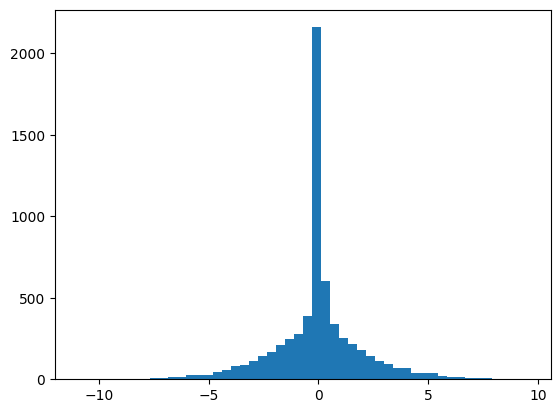

In [24]:
plt.hist(h_preact.view(-1).tolist(),50)

(array([826., 180., 114., 107.,  73.,  61.,  53.,  63.,  50.,  46.,  67.,
         43.,  46.,  57.,  43.,  48.,  52.,  39.,  48.,  67.,  74.,  88.,
        165., 317., 478., 452., 335., 150., 103.,  82.,  69.,  61.,  49.,
         57.,  53.,  51.,  50.,  39.,  57.,  60.,  47.,  54.,  65.,  57.,
         58.,  75.,  92., 111., 185., 783.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

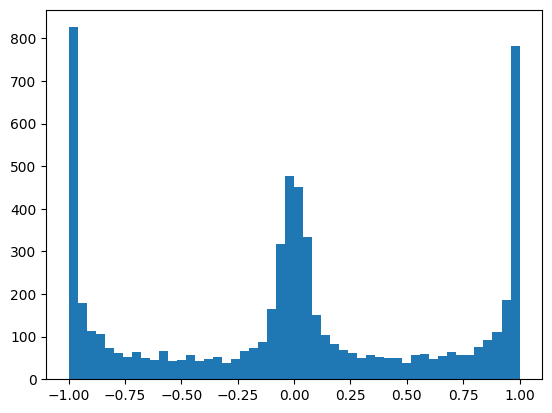

In [25]:
plt.hist(h.view(-1).tolist(),50)

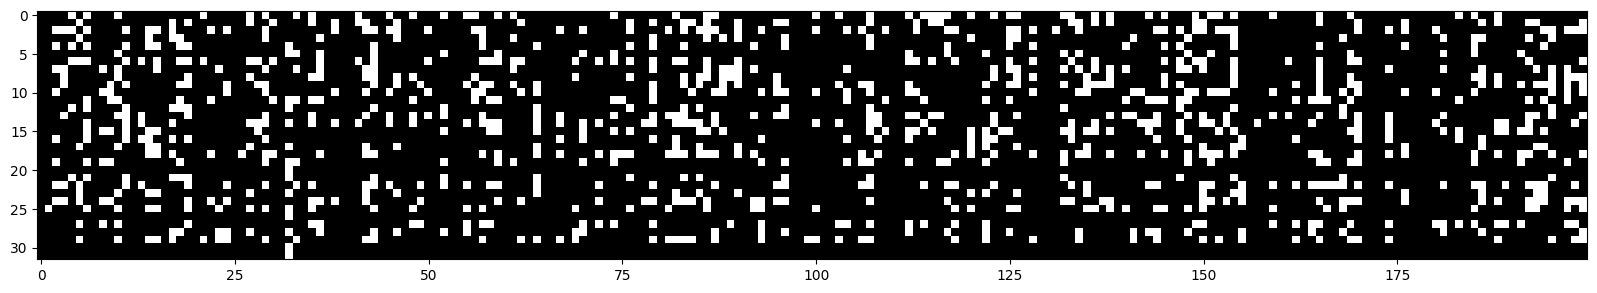

In [26]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

So much more time is spent on learning.

train Loss:  2.0618765354156494
dev Loss:  2.1173970699310303


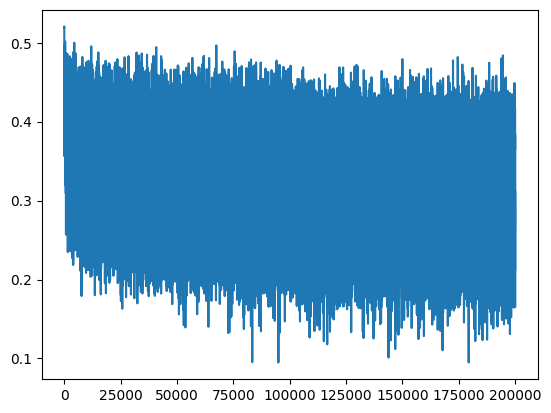

In [27]:
split_loss('train')
split_loss('dev')
plt.plot(steps_l, loss_l)

1) Original NN with improper initialization   
  
    **train Loss**:  2.118352174758911    
    **dev Loss**:  2.169837474822998    

2) After fixing intial state of the predicting next character to be equally likely, which is fixing softmax confidently wrong   
  
    **train Loss**:  2.0691044330596924   
    **dev Loss**:  2.136845588684082   

3) After fixing the tanh layer, where the gradient was 0 as majority of the inputs hpreact fell in close to -1 or 1   
  
    **train Loss**:  2.060110092163086   
    **dev Loss**:  2.112579107284546   

So as we notice our train and dev loss changing reduced with great initialization.

For small neural networks even if we ignore this, it will not cause much of a problem but with big neural networks it may lead to neural network not being trained/weights getting updated.

Now for large Neural Networks how should we setup these weights ?

Lets see that


tensor(-0.0002) tensor(1.0009)
tensor(0.0031) tensor(3.2175)


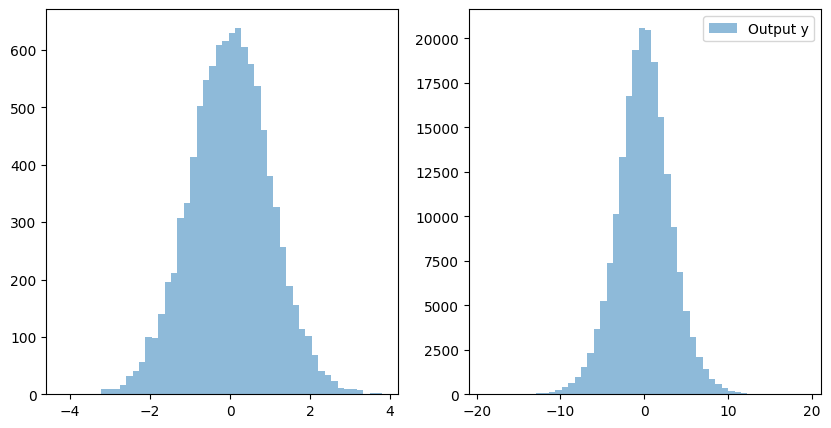

In [28]:
x = torch.randn(1000, 10) # samples drawn from a normal distribution
w = torch.randn(10, 200) # this is a 200 neuron layer weights
y = x @ w 
print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, alpha=0.5, label='Input x')
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, alpha=0.5, label='Output y')
plt.legend()

We observe the standard deviation has been expanded to 3, which means the gausian is expanding.
We dont want this, we want neural nets to have relatively similar activations which is we want unit gausian throughout the neural net.

Why is this bad?   
1) If every layer expands (or shrinks) the variance:

2) With many layers, activations blow up (explode) or vanish.

3) This makes gradients unstable (exploding/vanishing gradients).

That’s why we want each layer’s output distribution to remain close to unit Gaussian (mean ~0, std ~1).

Note:
1) Unit Gaussian: mean = 0 and standard deviation = 1
2) fan_in: number of inputs per neuron.

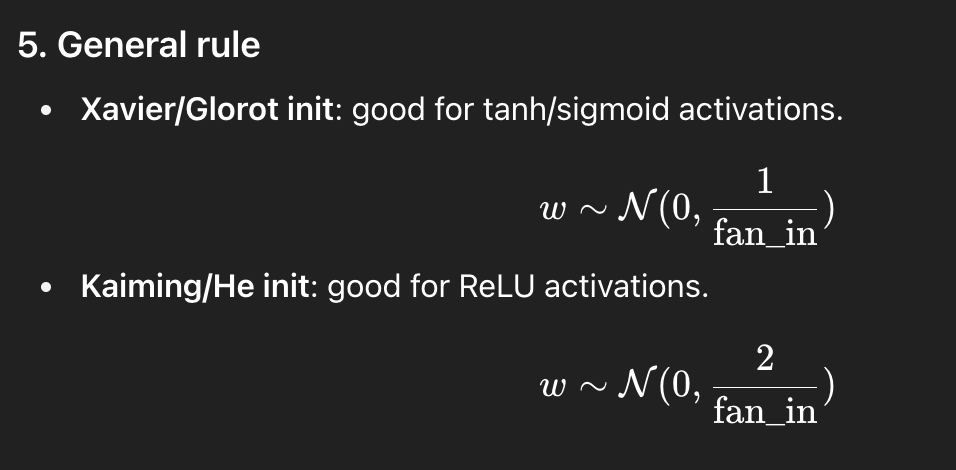

In [29]:
import torch
import matplotlib.pyplot as plt

tensor(-0.0125) tensor(0.9964)
tensor(0.0009) tensor(1.0070)


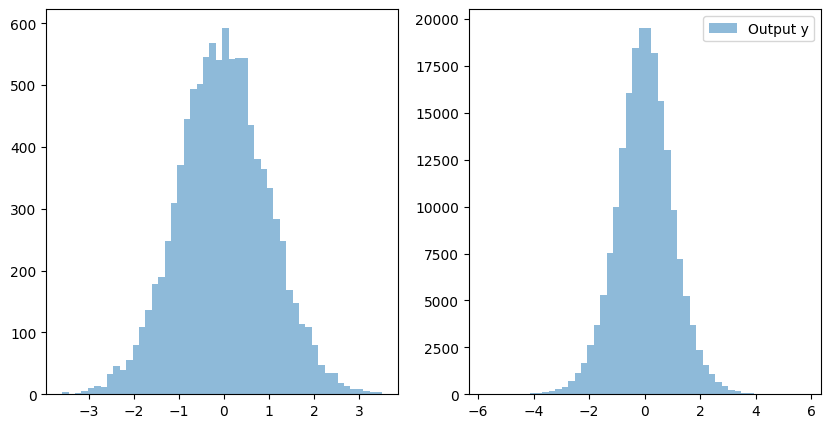

In [30]:
x = torch.randn(1000, 10) # samples drawn from a normal distribution
w = torch.randn(10, 200) / (10**0.5) # this is a 200 neuron layer weights
y = x @ w 
print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, alpha=0.5, label='Input x')
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, alpha=0.5, label='Output y')
plt.legend()

How to best initialize neural networks ?

In case of multilayer perceptrons we have fairly deep neural networks that have non-linearities in between and we want to make sure the activations are well behaved where they dont expand to inf or shrink to zero, so how to initialize the weights so that these activations taken on reasonable values throughout the network.

### 

Not only the activations of the forward pass of the neural net but also studies the back-propagation, and we need to make sure the gradients are also well behaved.

kaiming_normal() -> do we need to normalize the activations or the gradients to be always unit gausian with 0 mean and 1 standard deviation.


what we are doing is, we take the output distribution of the matrix multiplication and then we are squashing it in some way, ReLU squashes by taking all the values below zero to zero. tanh also squeezes the data (matrix mul), to make sure its still a unit gausian we give a gain of sqrt(2) 

With modern developments, it became less important to initialze the weights right, some of the modern solutions are residual connections and use of normalization layers like batch normalization, layer normalization, group normalization. and better optimizers like RMS Prop and Adam optimizer.  

Note: W1 = torch.randn((n_embed*block_size,n_hidden),generator=g) * 0.1, when we multiply 0.1 to it we are deciding its standard deviation which is 0.1 as 1 is the standard deviation for torch.randn((n_embed*block_size,n_hidden),generator=g). 


In [31]:
# Now to prevent this tanh ditribution being 1 and -1 more we need to make
# hpreact closer to 0, we can do this by scaling the weights down
# as our activation function is tanh we will use 5/3 as the gain and
# fan_in is the number of input given to a neuron.

n_embed = 10
n_hidden = 200

g = torch.Generator().manual_seed(345)
C = torch.randn((vocab_size,n_embed), generator=g)
W1 = torch.randn((n_embed*block_size,n_hidden),generator=g) * (5/3)/((n_embed*block_size)**0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden,vocab_size),generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True


In [32]:
# Lets train the neural net 

max_steps = 200000
batch_size = 32
loss_l = []
steps_l = []

for epoch in range(max_steps):
    ix = torch.randint(0, X_train.shape[0],(batch_size,),generator=g)

    Xb, Yb = X_train[ix], Y_train[ix]

    emb = C[Xb] # (batch_size, block_size, n_embed)
    h_preact = emb.view(-1,block_size*n_embed) @ W1 + b1
    h = torch.tanh(h_preact)
    logits = h @ W2 + b2

    loss = F.cross_entropy(logits,Yb)

    steps_l.append(epoch)
    loss_l.append(loss.log10().item()) # smoothens the loss for good visualization

    for p in parameters:
        p.grad = None
    
    loss.backward()

    lr = 0.1 if epoch < int((max_steps)/2) else 0.01
    for p in parameters:
        p.data += -lr*p.grad

    # tracking stats
    if epoch % 10000 == 0:
        print(f"Step {epoch}/{max_steps:7d}, Loss: {loss.item():.4f}, Learning Rate: {lr:.4f}")
    
    # break


Step 0/ 200000, Loss: 3.3163, Learning Rate: 0.1000
Step 10000/ 200000, Loss: 2.1895, Learning Rate: 0.1000
Step 20000/ 200000, Loss: 2.2244, Learning Rate: 0.1000
Step 30000/ 200000, Loss: 2.4737, Learning Rate: 0.1000
Step 40000/ 200000, Loss: 2.0346, Learning Rate: 0.1000
Step 50000/ 200000, Loss: 1.7506, Learning Rate: 0.1000
Step 60000/ 200000, Loss: 2.0425, Learning Rate: 0.1000
Step 70000/ 200000, Loss: 2.0071, Learning Rate: 0.1000
Step 80000/ 200000, Loss: 2.0098, Learning Rate: 0.1000
Step 90000/ 200000, Loss: 2.0228, Learning Rate: 0.1000
Step 100000/ 200000, Loss: 2.1089, Learning Rate: 0.0100
Step 110000/ 200000, Loss: 1.8328, Learning Rate: 0.0100
Step 120000/ 200000, Loss: 2.0302, Learning Rate: 0.0100
Step 130000/ 200000, Loss: 2.0753, Learning Rate: 0.0100
Step 140000/ 200000, Loss: 2.0858, Learning Rate: 0.0100
Step 150000/ 200000, Loss: 2.1166, Learning Rate: 0.0100
Step 160000/ 200000, Loss: 1.7215, Learning Rate: 0.0100
Step 170000/ 200000, Loss: 1.9407, Learning R

In [33]:
split_loss('train')
split_loss('dev')
# plt.plot(steps_l, loss_l)

train Loss:  2.0390686988830566
dev Loss:  2.1090962886810303


1) Original NN with improper initialization   
  
    **train Loss**:  2.118352174758911    
    **dev Loss**:  2.169837474822998    

2) After fixing intial state of the predicting next character to be equally likely, which is fixing softmax confidently wrong   
  
    **train Loss**:  2.0691044330596924   
    **dev Loss**:  2.136845588684082   

3) After fixing the tanh layer, where the gradient was 0 as majority of the inputs hpreact fell in close to -1 or 1   
  
    **train Loss**:  2.060110092163086   
    **dev Loss**:  2.112579107284546   

4) Using Xavier/Glorot Initialization of weights:
   
   **train Loss**:  2.0450198650360107   
   **dev Loss**:  2.108264923095703

Batch-Normalization:

The preactivations shouln't be too small (then tanh will not be doing anything) and also we dont want them to be huge (as that will make tanh saturatured, causing no updation in weights).

We want the preactivations to be roughly gaussian as stated above.

In [34]:
# Here test is refering to hpreact.
# For those 32 inputs what is the mean of each of those 200 neurons
# we want the mean to be close to 0 and std to be close to 1
# so that tanh is not saturated and also not too small
# we want the preactivations to be roughly gaussian as stated above.

test = torch.randn(32,200)
test.mean(0,keepdim=True).shape

torch.Size([1, 200])

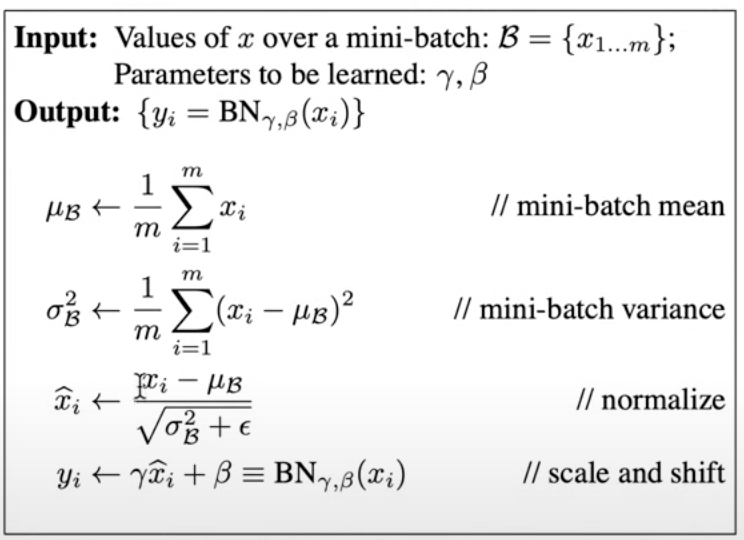

Applying this, every single neuron now has a firing rate which will be a unit gaussian on the 1 batch.

We want them to be roughly gaussian but only at the initialization, and dont want to force it to be unit gaussian. As we want the neural net to move the distribution around to make it more diffuse or more sharp and make some tanh neurons to be more trigger happy and some tanh neurons to be less trigger happy. And we want the back-propagation to tell us how to make this distirbution move around.

To do this in training we introduce scale and shift. 


In [ ]:
n_embed = 10
n_hidden = 200

g = torch.Generator().manual_seed(345)
C = torch.randn((vocab_size,n_embed), generator=g)
W1 = torch.randn((n_embed*block_size,n_hidden),generator=g) * (5/3)/((n_embed*block_size)**0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden,vocab_size),generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

bgain = torch.ones((1,n_hidden)) # initially the distribution is unit gaussian and is centered around 0
bbias = torch.zeros((1,n_hidden)) # but with training the distribution can move around.


parameters = [C, W1, b1, W2, b2, bgain, bbias]

for p in parameters:
    p.requires_grad = True


By doing this, for the first batch it will be exactly unit gaussian but with training other batches it will get into different distribution forms.

In [ ]:
# Lets train the neural net 

max_steps = 200000
batch_size = 32
loss_l = []
steps_l = []

for epoch in range(max_steps):
    ix = torch.randint(0, X_train.shape[0],(batch_size,),generator=g)

    Xb, Yb = X_train[ix], Y_train[ix]

    emb = C[Xb] # (batch_size, block_size, n_embed)
    h_preact = emb.view(-1,block_size*n_embed) @ W1 + b1
    # batch normalization
    bnmeani = h_preact.mean(0,keepdim=True)
    bnstdi = h_preact.std(0,keepdim=True)
    h_preact = bgain * ((h_preact - bnmeani) / bnstdi) + bbias
    
    h = torch.tanh(h_preact)
    logits = h @ W2 + b2

    loss = F.cross_entropy(logits,Yb)

    steps_l.append(epoch)
    loss_l.append(loss.log10().item()) # smoothens the loss for good visualization

    for p in parameters:
        p.grad = None
    
    loss.backward()

    lr = 0.1 if epoch < int((max_steps)/2) else 0.01
    for p in parameters:
        p.data += -lr*p.grad

    # tracking stats
    if epoch % 10000 == 0:
        print(f"Step {epoch}/{max_steps:7d}, Loss: {loss.item():.4f}, Learning Rate: {lr:.4f}")
    
    # break


Step 0/ 200000, Loss: 3.3096, Learning Rate: 0.1000
Step 10000/ 200000, Loss: 2.1688, Learning Rate: 0.1000
Step 20000/ 200000, Loss: 2.2532, Learning Rate: 0.1000
Step 30000/ 200000, Loss: 2.4902, Learning Rate: 0.1000
Step 40000/ 200000, Loss: 2.2167, Learning Rate: 0.1000
Step 50000/ 200000, Loss: 1.7752, Learning Rate: 0.1000
Step 60000/ 200000, Loss: 2.1805, Learning Rate: 0.1000
Step 70000/ 200000, Loss: 2.1519, Learning Rate: 0.1000
Step 80000/ 200000, Loss: 2.0822, Learning Rate: 0.1000
Step 90000/ 200000, Loss: 2.2500, Learning Rate: 0.1000
Step 100000/ 200000, Loss: 2.1992, Learning Rate: 0.0100
Step 110000/ 200000, Loss: 1.8067, Learning Rate: 0.0100
Step 120000/ 200000, Loss: 2.1744, Learning Rate: 0.0100
Step 130000/ 200000, Loss: 2.0570, Learning Rate: 0.0100
Step 140000/ 200000, Loss: 2.0876, Learning Rate: 0.0100
Step 150000/ 200000, Loss: 2.0748, Learning Rate: 0.0100
Step 160000/ 200000, Loss: 1.9512, Learning Rate: 0.0100
Step 170000/ 200000, Loss: 1.9608, Learning R

In [37]:
@torch.no_grad() # decorator this prevents gradient tracking which causes the evaluation results to be forward pass faster

def split_loss(split):
    x,y = {
        'train': (X_train,Y_train),
        'dev': (X_dev,Y_dev),
        'test': (X_test,Y_test)
    }[split]

    emb = C[x]

    h_preact = emb.view(-1,block_size*n_embed) @ W1 + b1
    # batch normalization
    h_preact = h_preact - h_preact.mean(0,keepdim=True)
    h_preact = bgain * (h_preact / h_preact.std(0,keepdim=True)) + bbias
    h = torch.tanh(h_preact)
    
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,y)

    print(f'{split} Loss: ',loss.item())

split_loss('train')
split_loss('dev')
    

train Loss:  2.067873239517212
dev Loss:  2.1127560138702393


1) Original NN with improper initialization   
  
    **train Loss**:  2.118352174758911    
    **dev Loss**:  2.169837474822998    

2) After fixing intial state of the predicting next character to be equally likely, which is fixing softmax confidently wrong   
  
    **train Loss**:  2.0691044330596924   
    **dev Loss**:  2.136845588684082   

3) After fixing the tanh layer, where the gradient was 0 as majority of the inputs hpreact fell in close to -1 or 1   
  
    **train Loss**:  2.060110092163086   
    **dev Loss**:  2.112579107284546   

4) Using Xavier/Glorot Initialization of weights:
   
   **train Loss**:  2.0450198650360107   
   **dev Loss**:  2.108264923095703

5) With Batch Normalization:
   
   **Train Loss**: 2.067873239517212   
   **Dev Losses**: 2.1127560138702393

Here we observed that there is no difference in 3) after fixing the tanh layer and then the 5) point where we have used the Batch normalization which produces a unit gaussian output from each 200 neuron at its initialization.

We are dealing with a simple neural network, that has just a single hidden layer, infact we have roughly figured out what the scale of W1 should be (0.2 (random) and then 5/3/sqrt(fan_in)) such that these pre-activations (h_preact) already have a gaussian distribution. Hence batch normalization isnt doing much here.

But once we have a deeper neural net (alot of different operations), it becomes very difficult to tune the scales of the weights matrix of the neural net such that all the activations through out the NN are roughly gaussian.

So we apply a batch normalization layer just a linear layer or a convolution layer everywhere in the neural net.

##### Note:

The stability offered by batch normalization often comes at a terrible cost.

First lets say we have a single sample it passes throught the neural net, and for that input it generates a particular output so we arrive at the logits for a particular sample.

But when we start to use batches for improving the efficiency of our training, because of the normalization through the batch we are coupling these examples mathematically and in the forward pass and the backward pass of the neural net, (as each batch of 32 it selects random sample and then based on those sample the batch normalization converts then to a gaussian distribution, hence for that input sample it will output differently based on the other input samples which come along with it in the training batch, hence this causes a jitter in the output for that same sample input). Now the hidden state h_preact and the logits are not only the function of the any one given sample input but also the function of all the other sample inputs present in that batch.

Hence depending on the other examples that are present in the batch it will output differently each time, causing a jitter in the logits, but in a strange way this actually turns out to be good in neural net training, the reason being we can think it as of a regularizer. this makes it harded for the neural net to overfit to these input sample as the output is not only dependent on the given sample input but also on the other samples which come in that batch which causes data augmentation preventing kinda overfitting.

But we dont like this property that the examples in the batch are coupled mathematically in forward pass and in the backward pass which often leads to strange results and bugs hence we have other normalization techniques (that do not couple the examples in the batch).

1) Layer Normalization
2) Instance Normalization
3) Group Normalization

But this worked extremely well, it has the regularizing effect its stabilized training and people have being trying to remove it. But its hard as it works quite well (becuase of its regularizing effect and controlling the activations and distributions in the neural net). 


#### Now lets feed a single input to our neural network

For which we need each neuron mean, and each neuron standard deviation, as in our training we feed as a batch where we compute the mean and standard deviation for each of the neurons based on those batch samples.

We will calculate this based on the training set.

In [41]:
n_embed = 10
n_hidden = 200

g = torch.Generator().manual_seed(345)
C = torch.randn((vocab_size,n_embed), generator=g)
W1 = torch.randn((n_embed*block_size,n_hidden),generator=g) * (5/3)/((n_embed*block_size)**0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden,vocab_size),generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

bgain = torch.ones((1,n_hidden)) # initially the distribution is unit gaussian and is centered around 0
bbias = torch.zeros((1,n_hidden)) # but with training the distribution can move around.

bnmean_running = torch.zeros((1,n_hidden))
bnstd_running = torch.ones((1,n_hidden))

parameters = [C, W1, b1, W2, b2, bgain, bbias]

for p in parameters:
    p.requires_grad = True


In [ ]:
# After training we are trying to get the mean and std of hpreact w.r.t train data
with torch.no_grad():
    emb = C[X_train]
    emb_cat = emb.view(-1,block_size*n_embed)
    h_preact = emb_cat @ W1 + b1
     
    bnmean = h_preact.mean(0,keepdim=True)
    bnstd = h_preact.std(0,keepdim=True)

In [42]:
# We can also parallely update the running mean and std, and get the batch_mean and batch_std

max_steps = 200000
batch_size = 32
loss_l = []
steps_l = []

for epoch in range(max_steps):
    ix = torch.randint(0, X_train.shape[0],(batch_size,),generator=g)

    Xb, Yb = X_train[ix], Y_train[ix]

    emb = C[Xb] # (batch_size, block_size, n_embed)
    h_preact = emb.view(-1,block_size*n_embed) @ W1 + b1
    # batch normalization
    bnmeani = h_preact.mean(0,keepdim=True)
    bnstdi = h_preact.std(0,keepdim=True)
    h_preact = bgain * ((h_preact - bnmeani) / bnstdi) + bbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    h = torch.tanh(h_preact)
    logits = h @ W2 + b2

    loss = F.cross_entropy(logits,Yb)

    steps_l.append(epoch)
    loss_l.append(loss.log10().item()) # smoothens the loss for good visualization

    for p in parameters:
        p.grad = None
    
    loss.backward()

    lr = 0.1 if epoch < int((max_steps)/2) else 0.01
    for p in parameters:
        p.data += -lr*p.grad

    # tracking stats
    if epoch % 10000 == 0:
        print(f"Step {epoch}/{max_steps:7d}, Loss: {loss.item():.4f}, Learning Rate: {lr:.4f}")
    
    # break


Step 0/ 200000, Loss: 3.3096, Learning Rate: 0.1000
Step 10000/ 200000, Loss: 2.1688, Learning Rate: 0.1000
Step 20000/ 200000, Loss: 2.2532, Learning Rate: 0.1000
Step 30000/ 200000, Loss: 2.4902, Learning Rate: 0.1000
Step 40000/ 200000, Loss: 2.2167, Learning Rate: 0.1000
Step 50000/ 200000, Loss: 1.7752, Learning Rate: 0.1000
Step 60000/ 200000, Loss: 2.1805, Learning Rate: 0.1000
Step 70000/ 200000, Loss: 2.1519, Learning Rate: 0.1000
Step 80000/ 200000, Loss: 2.0822, Learning Rate: 0.1000
Step 90000/ 200000, Loss: 2.2500, Learning Rate: 0.1000
Step 100000/ 200000, Loss: 2.1992, Learning Rate: 0.0100
Step 110000/ 200000, Loss: 1.8067, Learning Rate: 0.0100
Step 120000/ 200000, Loss: 2.1744, Learning Rate: 0.0100
Step 130000/ 200000, Loss: 2.0570, Learning Rate: 0.0100
Step 140000/ 200000, Loss: 2.0876, Learning Rate: 0.0100
Step 150000/ 200000, Loss: 2.0748, Learning Rate: 0.0100
Step 160000/ 200000, Loss: 1.9512, Learning Rate: 0.0100
Step 170000/ 200000, Loss: 1.9608, Learning R

In [43]:
@torch.no_grad() # decorator this prevents gradient tracking which causes the evaluation results to be forward pass faster

def split_loss(split):
    x,y = {
        'train': (X_train,Y_train),
        'dev': (X_dev,Y_dev),
        'test': (X_test,Y_test)
    }[split]

    emb = C[x]

    h_preact = emb.view(-1,block_size*n_embed) @ W1 + b1
    # batch normalization
    h_preact = bgain * ((h_preact - bnmean_running) / bnstd_running) + bbias
    h = torch.tanh(h_preact)
    
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,y)

    print(f'{split} Loss: ',loss.item())

split_loss('train')
split_loss('dev')
    

train Loss:  2.0677340030670166
dev Loss:  2.1130940914154053


Note:

1) While calculating hp_react, we see due to batch normalization we actually dont need the bias b1, as while doing (hp_react - bnmean) it gets subtracted and hence no effect on logits.

2) Instead we have the batch normalization bias which actually takes care of biasing of the distribution.

Conclusion:

1) We are using batch normalization to control the statistics of the output in a neural net .
2) We usually add batch normalization after layers that have multiple multiplications like a linear layer or like a convolution layer.
3) Batch Normalization has parameters gain and the bias which are trained in Back-propagation. And it has 2 buffers which is the running mean and the standard deviation.


torch.nn.BatchNorm1d(num_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True, device=None, dtype=None)

1) momentum:
   * Here the 'momentum' is referring to the bnmean_running and bnstd_running updation happening while traveling, for example we have momentum = 0.001 set here.
   with torch.no_grad():  
      bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani   
      bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi  

   * If we have a very large batch_size then roughly we will get the same mean and std deviation for different batches, hence here we can keep high momentum value like 0.1, on other hand for small batch size we will use smaller momentum so that the mean and std value converges to the actual mean and std of the entire training set. 

2) Affine: wether in the batch normalization layer do we need bngain and bnbias to be learnable parameters.

3) track_running_stats: its referring to 
   with torch.no_grad():  
      bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani   
      bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi  
   Some times we want to calulate this in a different stage after training.

##### Summary:

1) If we have two confident miss-predictions, the activations are too messed up in the last layer we end up with hockey stick losses and if we fix this we get better loss at the end of the training because your training is not doing wasteful work.

2) Then we also saw the activations we dont want them to be squashed to be zero or explode to infinity, because we run into problems with all these non linearities in the neural net. We want everything to be fairly homogeneous (roughly gaussian) throughout the neural net.

3) As we saw we were coupling all the training (at batch level) examples, then while testing or deploying how do we use that to predict our output given a single input, for which we estimate the mean and the standard deviation once over the entire training set.

4) Most of the Researchers dont like this batch normalization layer as it causes bugs as we are causing a coupling in the examples in a batch (while training).



In [44]:
g = torch.Generator().manual_seed(42)

for _ in range(10):

    out = []
    context = [0] * block_size

    while True:
        emb = C[context]
        h = torch.tanh(emb.view(-1,block_size*n_embed) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits,dim=1)
        
        ix = torch.multinomial(probs,num_samples=1,generator=g).item()

        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

    

cashdyn.
kil.
gabikushyvaugustiflaynellawmangelillxsiyah.
jaquissomiangolgwondragnadem.
grachyjabquviciavaugg.
charlatwephalimaxxtringelixxevangelistorlendra.
greclyn.
sheplyn.
whden.
jaqumfsliciadovaldobgiltholuwarbextanorrethrystydi.
